# 📘 Analyse descriptive des codes CIM-10 (DP / DR / DA)

Ce notebook produit des **statistiques descriptives** et des **visualisations** à partir d’un CSV issu du script d’extraction.

Colonnes attendues :
- `text` : compte rendu médical (texte brut)
- `dp_code` : diagnostic principal
- `dr_code` : diagnostic relié (peut être vide)
- `da_codes` : liste JSON ou chaîne séparée de codes CIM-10 associés

⚙️ Il faut simplement modifier le chemin du CSV dans la première cellule de code.

In [ ]:
! pip install pandas numpy matplotlib seaborn

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

plt.rcParams['figure.figsize'] = (10, 6)
sns.set(style='whitegrid')
pd.set_option('display.max_rows', 50)

# 🔁 adapte ce chemin selon ton environnement
CSV_PATH = 'csv_data/train.csv'

df = pd.read_csv(CSV_PATH)
print(f"Fichier chargé : {CSV_PATH} ({len(df)} lignes)")
display(df.head())

Fichier chargé : csv_data/train.csv (10000 lignes)


,text,dp_code,dr_code,da_codes
0,Générez le codage CIM-10 du résumé strandisé d...,Z5101,C793,"[""G819"", ""I10"", ""R2630"", ""C792"", ""C798""]"
1,Générez le codage CIM-10 du résumé strandisé d...,M7134,NaN,"[""W450"", ""W4599"", ""W459"", ""S618""]"
2,Générez le codage CIM-10 du résumé strandisé d...,S1220,NaN,"[""G831"", ""F1026"", ""W00"", ""T797""]"
3,Générez le codage CIM-10 du résumé strandisé d...,Z470,NaN,"[""C910"", ""I10"", ""F1024"", ""C794"", ""C771"", ""C780..."
4,Générez le codage CIM-10 du résumé strandisé d...,C187,NaN,"[""G308"", ""Z515"", ""I10"", ""R64"", ""C786"", ""C780"",..."


In [9]:
def parse_da_list(x):
    if pd.isna(x) or str(x).strip() == '':
        return []
    try:
        val = ast.literal_eval(str(x))
        if isinstance(val, list):
            return [str(v).strip().upper() for v in val if v]
    except Exception:
        return [s.strip().upper() for s in str(x).split(';') if s.strip()]
    return []

df['da_list'] = df['da_codes'].apply(parse_da_list)
df['n_da'] = df['da_list'].apply(len)
display(df[['da_codes', 'da_list', 'n_da']].head())

,da_codes,da_list,n_da
0,"[""G819"", ""I10"", ""R2630"", ""C792"", ""C798""]","[G819, I10, R2630, C792, C798]",5
1,"[""W450"", ""W4599"", ""W459"", ""S618""]","[W450, W4599, W459, S618]",4
2,"[""G831"", ""F1026"", ""W00"", ""T797""]","[G831, F1026, W00, T797]",4
3,"[""C910"", ""I10"", ""F1024"", ""C794"", ""C771"", ""C780...","[C910, I10, F1024, C794, C771, C780, C774, C79...",11
4,"[""G308"", ""Z515"", ""I10"", ""R64"", ""C786"", ""C780"",...","[G308, Z515, I10, R64, C786, C780, C793, K632,...",9


In [10]:
dp_counts = df['dp_code'].value_counts(dropna=True)
n_unique_dp = df['dp_code'].nunique(dropna=True)
n_missing_dp = df['dp_code'].isna().sum() + (df['dp_code'] == '').sum()

print(f"Nombre total de lignes avec DP valide : {len(df) - n_missing_dp}")
print(f"Nombre de codes DP distincts : {n_unique_dp}")
display(dp_counts.head(10))

Nombre total de lignes avec DP valide : 9997
Nombre de codes DP distincts : 2165


dp_code
Z511      476
Z512      120
Z515      119
Z452      114
Z04802    100
Z5101      95
C793       74
Z04880     66
Z5100      62
Z04801     55
Name: count, dtype: int64

/tmp/ipykernel_19565/559426678.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_dp.index, x=top_dp.values, palette='viridis')


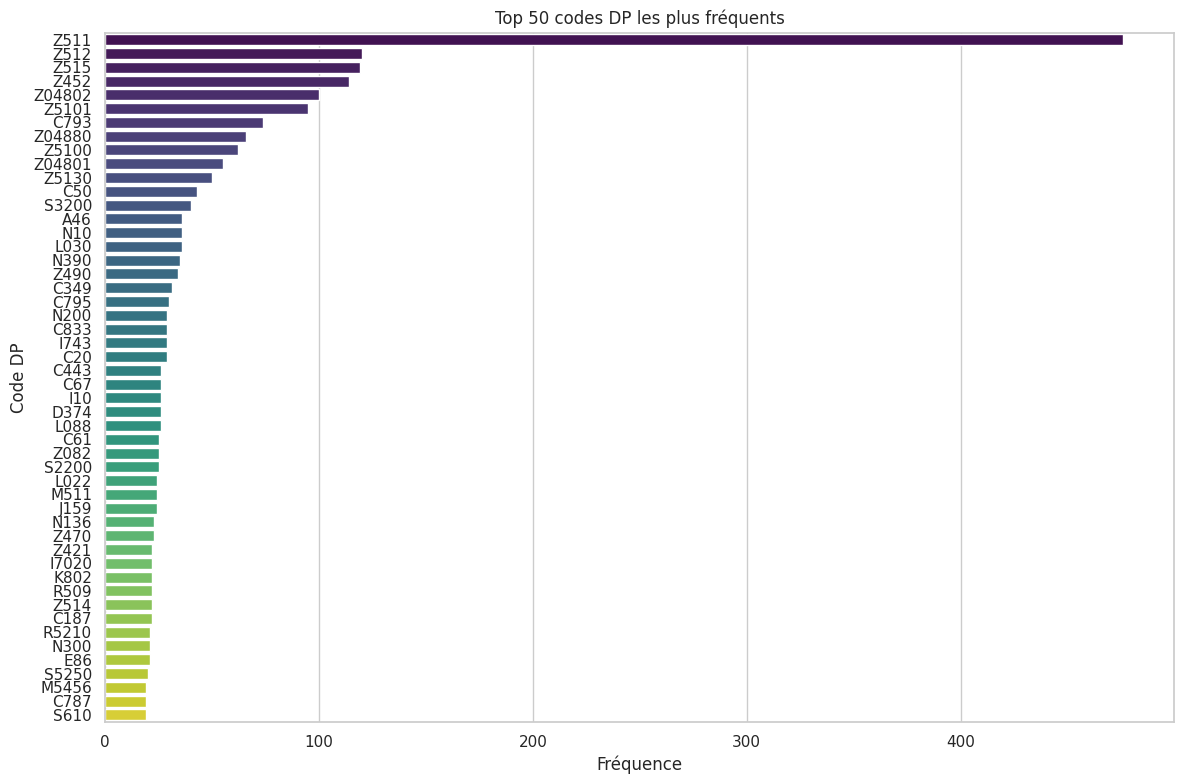

In [12]:
top_n = 50
top_dp = dp_counts.head(top_n)
plt.figure(figsize=(12, 8))
sns.barplot(y=top_dp.index, x=top_dp.values, palette='viridis')
plt.title(f'Top {top_n} codes DP les plus fréquents')
plt.xlabel('Fréquence')
plt.ylabel('Code DP')
plt.tight_layout()
plt.show()

In [13]:
has_dr = df['dr_code'].notna() & (df['dr_code'].astype(str).str.strip() != '')
pct_with_dr = 100 * has_dr.mean()
print(f"Pourcentage de séjours avec un diagnostic relié (DR) : {pct_with_dr:.2f}%")

Pourcentage de séjours avec un diagnostic relié (DR) : 14.06%


count    10000.000000
mean         5.555700
std          2.984994
min          0.000000
25%          3.000000
50%          5.000000
75%          8.000000
max         16.000000
Name: n_da, dtype: float64

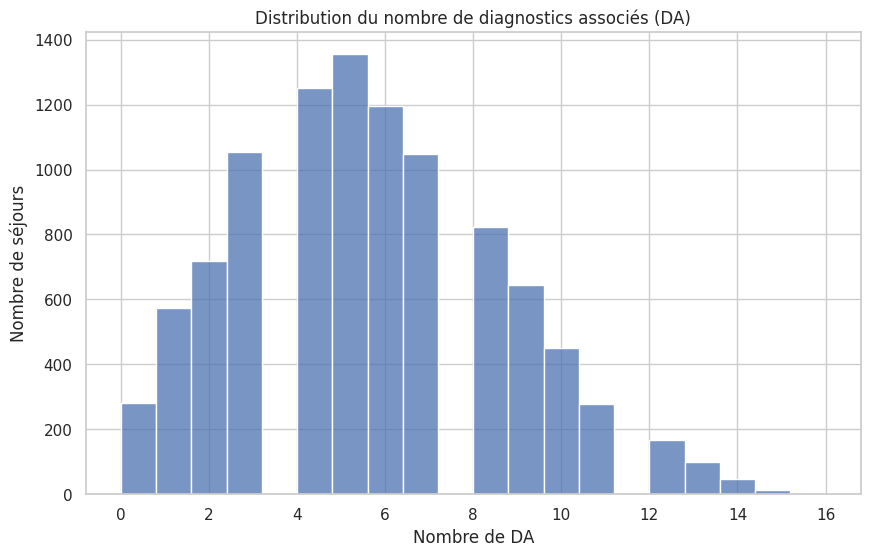

In [14]:
display(df['n_da'].describe())
sns.histplot(df['n_da'], bins=20, kde=False)
plt.title('Distribution du nombre de diagnostics associés (DA)')
plt.xlabel('Nombre de DA')
plt.ylabel('Nombre de séjours')
plt.show()

count    10000.000000
mean      6708.930600
std       2480.423638
min        126.000000
25%       4878.750000
50%       6769.500000
75%       8474.000000
max      17769.000000
Name: text_len, dtype: float64

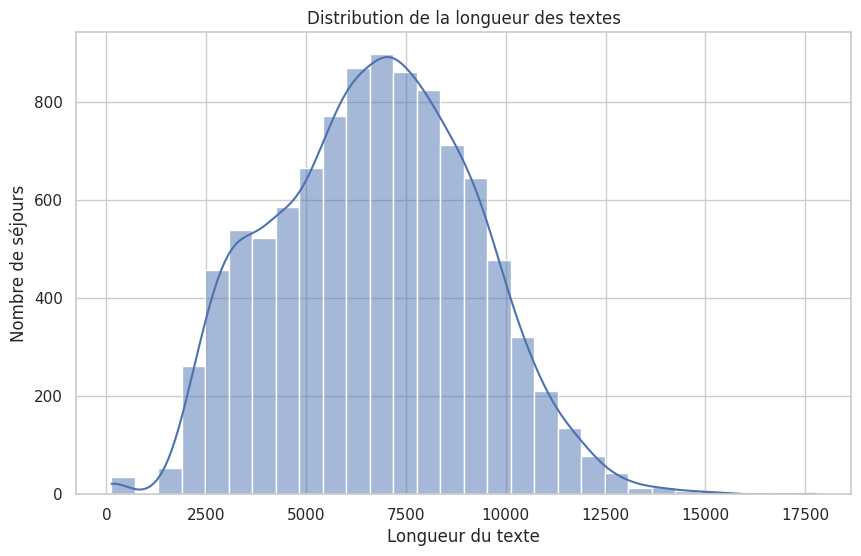

In [15]:
df['text_len'] = df['text'].astype(str).apply(len)
display(df['text_len'].describe())
sns.histplot(df['text_len'], bins=30, kde=True)
plt.title('Distribution de la longueur des textes')
plt.xlabel('Longueur du texte')
plt.ylabel('Nombre de séjours')
plt.show()

count    10000.000000
mean         6.696000
std          3.036199
min          0.000000
25%          4.000000
50%          6.000000
75%          9.000000
max         17.000000
Name: n_total_codes, dtype: float64

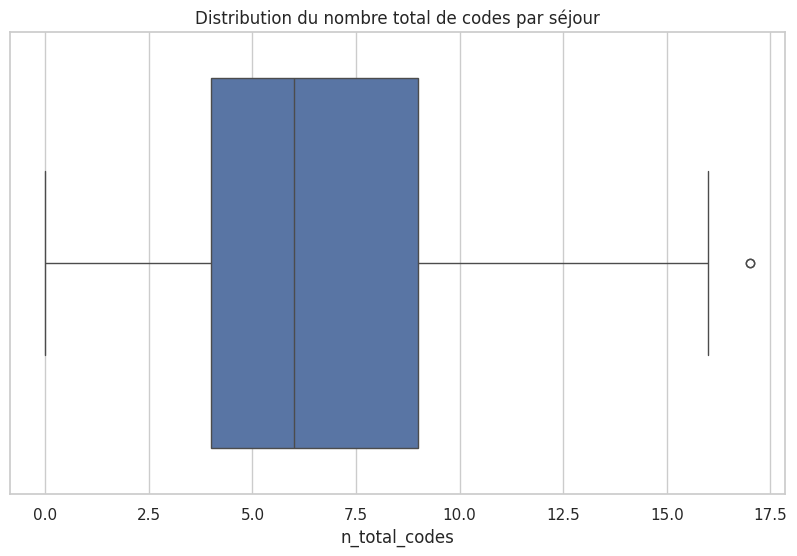

In [16]:
df['n_total_codes'] = (
    (df['dp_code'].notna() & (df['dp_code'].astype(str).str.strip() != '')).astype(int)
    + (df['dr_code'].notna() & (df['dr_code'].astype(str).str.strip() != '')).astype(int)
    + df['n_da']
)
display(df['n_total_codes'].describe())
sns.boxplot(x=df['n_total_codes'])
plt.title('Distribution du nombre total de codes par séjour')
plt.show()

/tmp/ipykernel_19565/1713890321.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=dr_counts.head(20).index, x=dr_counts.head(20).values, palette='coolwarm')


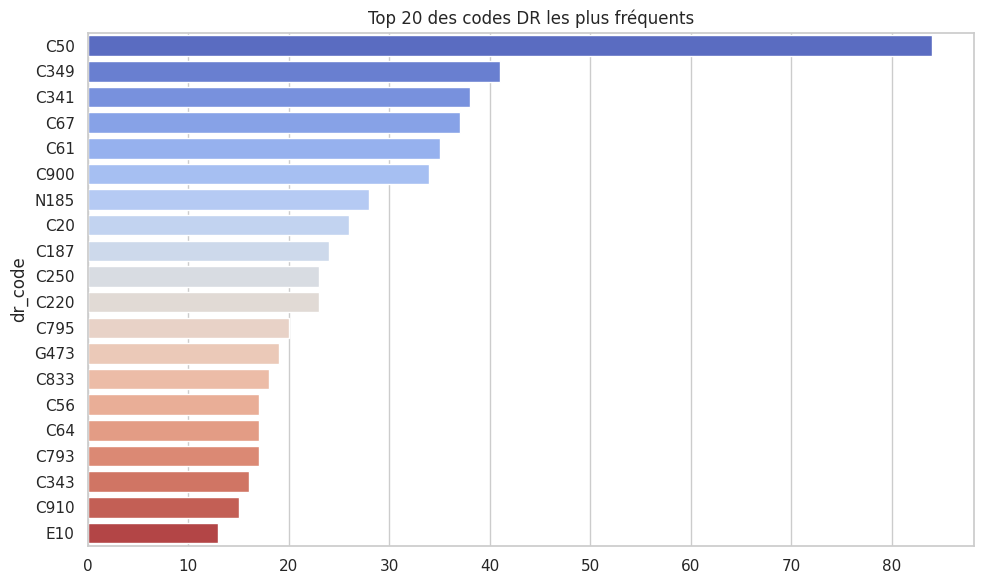

In [17]:
dr_counts = df.loc[has_dr, 'dr_code'].value_counts()
sns.barplot(y=dr_counts.head(20).index, x=dr_counts.head(20).values, palette='coolwarm')
plt.title('Top 20 des codes DR les plus fréquents')
plt.tight_layout()
plt.show()

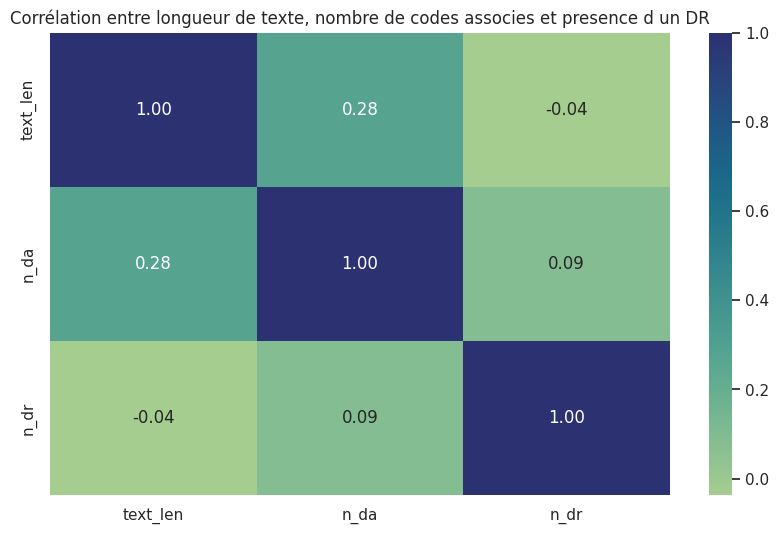

In [22]:
df['n_dr'] = (
    (df['dr_code'].notna() & (df['dr_code'].astype(str).str.strip() != '')).astype(int)
)
corr = df[['text_len', 'n_da', 'n_dr']].corr()
sns.heatmap(corr, annot=True, cmap='crest', fmt='.2f')
plt.title('Corrélation entre longueur de texte, nombre de codes associes et presence d un DR')
plt.show()